### FNO(Fourier Neural Operator)与算子范数学习

首先简单介绍一种偏微分方程求解析解的方法：格林函数法  
对于如下的偏微分方程：
$$\mathcal{L}_a(y(x))=f(x),x\in D$$
其中$\mathcal{L}_a$是一个线性微分算子，下标a表示参数，我们有
$$y(x)=\int_{R^n}f(\xi)G(x;\xi)d\xi$$
其中G即为格林函数，满足
$$\mathcal{L}_aG(x;\xi)=\delta(x-\xi)$$
其中函数$\delta(x-\xi)$(即狄拉克函数)满足如下三个条件：  
(1)$\rho(x)=\int\rho(\xi)\delta(x-\xi)d\xi$  
(2)if $\xi=x,\delta(x-\xi)=\infty$;  $\xi\neq x,\delta(x-\xi)=0$  
(3)$\int\delta(x-\xi)d\xi=1$  
根据(2),(3)我们还有如下推论：
$$\forall x \in D,\int_D\delta(x-\xi)d\xi=1$$  
因此求解上述偏微分方程的步骤可以转为如下过程：  
(1)求解格林函数G满足$\mathcal{L}_aG(x;\xi)=\delta(x-\xi)$  
(2)$u(x)=\int_D \mathcal{L}_aG(x;\xi)d\xi$


根据上述格林函数，我们可以设计神经网络结构来求解微分算子。假设我们有如下微分方程：
$$
(\mathcal{L}_au)(x)=f(x),x\in D\\
u(x)=g(x),x\in \partial D
$$
其中a为参数，目标是求解算子$\mathcal{L}_a$，而格林函数成立的前提条件为叠加原理成立，也即$\mathcal{L}_a$为线性算子，我们使用神经网络的非线性激活函数，即可求解非线性算子。  
神经网络一般设计成多层的结构，层数用下标t表示，各层之间满足的关系式如下:
$$
v_{t+1}(x)=\sigma(Wv_t(x)+\int_D\kappa_{\phi}(x,y,a(x),a(y))v_t(y)\nu_x(dy))
$$
其中各个符号的意义为L:$v_{t}$为对应层的输出，$v_{0}$为$f(x)$，$\sigma$为激活函数，$\kappa_{\phi}$为神经网络，$a(x),a(y)$为参数，$\nu_x$表示Borel测度，在Lebesgue测度下$\nu_x(dy)=dy$。  
通过这样的神经网络，我们可以建立从参数a到函数u的映射，也可以建立f和u的映射，甚至g和u的映射

求解的框架的一般形式如下，其中$P$和$Q$可以理解成encoder(编码器)和decoder(解码器)，即使用神经网络映射成更高维度的channel space，然后最后再恢复回目标的channel space  
$$
v_0=P(x,a(x),a_{\epsilon}(x),\nabla a_{\epsilon}(x))+p\\
v_{t+1}=\sigma(Wv_t(x)+\int_{B(x,r)}\kappa_{\phi}(x,y,a(x),a(y))v_t(y)dy)\\
u(x)=Qv_T(x)+q
$$
而不同的operator则给出了不同的处理如下积分的方法
$$\int_D\kappa_{\phi}(x,y,a(x),a(y))v_t(y)\nu_x(dy)$$
以下采用FNO(Fourier Neural Operator)

FNO的结构图如下 
<div align=center><img src="2.jpg"></div>

上图，(a)即为上面求解框架的图示，输入为参数$a(x)$，经过P这个神经网络映射到高维，然后经历T个Fourier Layer，经过Q之后输出为$u(x)$。图(b)则表达了一个Fourier Layer内部都经历了哪些过程，其中$v(x)$进来以后，经过Fourier变换，将其转化到Fourier空间，R则是一个线性变换，目的是滤掉高频模态，然后用Fourier逆变换将其转化回源空间,R之所以不选用神经网络映射作者说是因为实验发现线性效果更好，下面那条支路就类似于ResNet的结构，可以防止梯度消失。相加求和之后，经过激活函数进行非线性映射。

Fourier Operator解决核积分问题的机制如下，以下用$\mathcal{K}$表示核积分算子，即
$$(\mathcal{K}(a;\phi)v_t)(x):=\int_D\kappa_{\phi}(x,y,a(x),a(y);\phi)v_t(y)dy$$
傅里叶变换的表达式如下:
$$(\mathcal{F}f)_j(k)=\int_Df_j(x)e^{-2i\pi<x,k>}dx,(\mathcal{F}^{-1}f)_j(x)=\int_Df_j(k)e^{-2i\pi<x,k>}dk$$
这样我们可以推出：
$$(\mathcal{K}(a;\phi)v_t)(x)=\mathcal{F}^{-1}(\mathcal{F}(\kappa_{\phi})\times\mathcal{F}(v_t))(x),\forall x\in D$$
而在神经网络中$\mathcal{F}(\kappa_{\phi})$即为$R_\phi$，因此我们有
$$(\mathcal{K}(a;\phi)v_t)(x)=\mathcal{F}^{-1}(R_\phi\times\mathcal{F}(v_t))(x),\forall x\in D$$
而从上面我们已经有：
$$
v_{t+1}(x)=\sigma(Wv_t(x)+(\mathcal{K}(a;\phi)v_t)(x))
$$
此即该模型的数学原理。

以下用代码实现FNO求解1-d Burgers’ equation。

1-d Burgers’ equation的形式如下：
$$
\partial_tu(x,t)+\partial_x(u^2(x,t)/2)=v\partial_{xx}u(x,t),x\in(0,1),t\in(0,1]\\
u(x,0)=u_0(x),x\in(0,1)
$$
我们要求解的算子$G$为$G:u_0\mapsto u(\cdot,1)$

首先导入需要的库

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from utilities3 import *
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)
device=torch.device("cuda" if torch.cuda.is_available else "cpu")

先设置超参数

In [7]:
ntrain=1000 #训练点的个数
ntest=100 #测试点的个数

sub = 2**3 #采样频率
h = 2**13 // sub #网格大小除以采样频率
s = h #神经网络输入中每个数据点所包含的点的个数

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16#线性变换R所要保留的频率数
width = 64#线性变换的层数

接下来我们先从burgers_data_R10.mat中导入我们需要的数据，实例化一个MatReader类(该类的定义包含在utilities3.py中)  
data的shape为(number of samples,grid size)

torch.Size([2048, 1024]) torch.Size([2048, 1024])


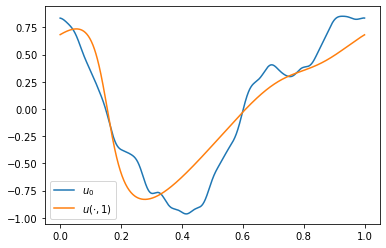

In [8]:
dataloader=MatReader('burgers_data_R10.mat')
x_data=dataloader.read_field('a')[:,::sub]#按照所给的采样频率采样
y_data=dataloader.read_field('u')[:,::sub]
print(x_data.size(),y_data.size())

test_x,test_y=x_data[0],y_data[0]
plt.plot(np.linspace(0,1,test_x.size()[0]),test_x,label=f'$u_0$')
plt.plot(np.linspace(0,1,test_x.size()[0]),test_y,label=f'$u(\cdot,1)$')
plt.legend(loc='best')

x_train=x_data[:ntrain,:]#取前ntrain个点作为训练集
y_train=y_data[:ntrain,:]
x_test=x_data[-ntest:,:]#取后ntest个点作为训练集
y_test=y_data[-ntest:,:]

x_train=x_train.reshape(ntrain,s,1)#修改测试数据的维度，在该例子中数据点的维度为(s,1)
x_test=x_test.reshape(ntest,s,1)

train_loader=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train,y_train),batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test,y_test),batch_size=batch_size,shuffle=False)


接下来定义Fourier layer，进行FFT，再通过线性变化层R，最后再经过IFT

In [10]:
class SpectralConv1d(nn.Module):
    #初始化，输入为输入通道数，输出通道数，以及Fourier modes，可以看作保留的频率大小
    def __init__(self,in_channels,out_channels,modes1) -> None:
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.modes1=modes1
        self.scale=(1/(in_channels*out_channels))
        #初始化权重，tensor的类型为cfloat，也即复浮点数
        self.weights1=nn.Parameter(self.scale*torch.rand(in_channels,out_channels,self.modes1,dtype=torch.cfloat))
    
    #定义复数张量乘法，我们需要把输入和权重相乘，最后一个维度保持不变，shape of tensor的变换为
    #(batch,in_channel,x),(in_channel,out_channel,x)->(batch,out_channel,x)
    def compl_mul1d(self,input,weights):
        return torch.einsum("bix,iox->box",input,weights)
    
    #向前传播
    def forward(self,x):
        batchsize=x.shape[0]
        #离散傅里叶变换，这里采用rfft，因为离散傅里叶变换中x[k]与x[n-k]项是共轭的，所以只需保留其中的N/2+1项
        x_ft=torch.fft.rfft(x)

        #初始化输出为全零矩阵，然后将我们要保留的频率的参数修改为输入和权重的乘积
        out_ft=torch.zeros(batchsize,self.out_channels,x.size(-1)//2+1,device=x.device,dtype=torch.cfloat)
        out_ft[:,:,:self.modes1]=self.compl_mul1d(x_ft[:,:,:self.modes1],self.weights1)

        #DFT逆变换
        x=torch.fft.irfft(out_ft,n=x.size(-1))
        return x

接下来定义神经网络，总共包含了4层Fourier layer，公式为
$$
v_{t+1}(x)=\sigma(Wv_t(x)+(\mathcal{K}(a;\phi)v_t)(x))
$$
因此我们还需要四个一维卷积参数W.  
我们首先通过线性层fc0将输入的维度转化为我们设定的维度，然后通过四个Fourier layer,最后再通过fc1和fc2降维并得到输出结果。

In [11]:
class FNO1d(nn.Module):
    #初始化输入为保留的频率，以及Fourier layer的宽度
    def __init__(self,modes,width) -> None:
        super().__init__()
        self.modes1=modes
        self.width=width
        self.padding=2 # 如果输入不是周期性的，则需要填充域
        self.fc0=nn.Linear(2,self.width)#线性层

        #四层Fourier layer
        self.conv0=SpectralConv1d(self.width,self.width,self.modes1)
        self.conv1=SpectralConv1d(self.width,self.width,self.modes1)
        self.conv2=SpectralConv1d(self.width,self.width,self.modes1)
        self.conv3=SpectralConv1d(self.width,self.width,self.modes1)

        self.w0=nn.Conv1d(self.width,self.width,1)
        self.w1=nn.Conv1d(self.width,self.width,1)
        self.w2=nn.Conv1d(self.width,self.width,1)
        self.w3=nn.Conv1d(self.width,self.width,1)

        self.fc1=nn.Linear(self.width,128)
        self.fc2=nn.Linear(128,1)
    
    def forward(self,x):
        #处理输入数据并通过线性层
        grid=self.get_grid(x.shape,x.device)
        x=torch.cat((x,grid),dim=-1)
        x=self.fc0(x)
        x=x.permute(0,2,1)
        #x=F.pad(x,[0,self.padding])#如果输入不是周期性的，则需要填充域
        
        #接下来经过四层Fourier layer
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #最后再变换维度，并通过线性层
        # x = x[..., :-self.padding] #如果输入不是周期性的，则需要填充域
        x=x.permute(0,2,1)
        x=self.fc1(x)
        x=F.gelu(x)
        x=self.fc2(x)
        return x
    
    def get_grid(self,shape,device):
        batchsize,size_x=shape[0],shape[1]
        gridx=torch.tensor(np.linspace(0,1,size_x),dtype=torch.float)
        gridx=gridx.reshape(1,size_x,1).repeat([batchsize,1,1])
        return gridx.to(device)

model=FNO1d(modes,width).to(device)
print(count_params(model))
X=torch.rand(1,s,1).to(device)
print(model(X).size())
print(model)

549569
torch.Size([1, 1024, 1])
FNO1d(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


注：这里的激活函数采用GELU函数，其数学定义为
$$GELU(x)=0.5x(1+tan(\sqrt{\frac{2}{\pi}}(x+0.044715x^3)))$$
画出与RELU函数的对比图像如下，可以看出其与RELU十分接近，但其在x=0处是可导的

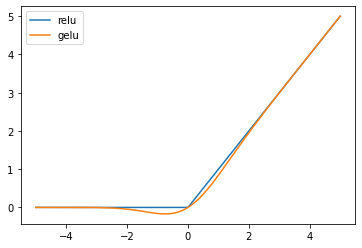

In [33]:
x=torch.linspace(-5,5,1000)
plt.plot(x,F.relu(x),label='relu')
plt.plot(x,F.gelu(x),label='gelu')
plt.legend(loc='best')

接下来开始训练过程

In [8]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)#Adam优化
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)#按步长减小学习率
myloss=LpLoss(size_average=False)#即两个向量之差的Lp范数，其中p默认为2

for epoch in range(epochs):
    model.train()
    train_l2=0
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        out=model(x)
        l2=myloss(out.view(batch_size,-1),y.view(batch_size,-1))
        optimizer.zero_grad()
        l2.backward()
        optimizer.step()
        train_l2+=l2.item()
    scheduler.step()
    if epoch%50==0:
        #测试集计算测试误差
        model.eval()
        test_l2=0.0
        with torch.no_grad():
            for x,y in test_loader:
                x,y=x.to(device),y.to(device)
                out=model(x)
                test_l2+=myloss(out.view(batch_size,-1),y.view(batch_size,-1)).item()
        
        train_l2/=ntrain
        test_l2/=ntest

        print("epoch:{},train_loss:{:.6f},test_loss:{:.6f}".format(epoch,train_l2,test_l2))
torch.save(model.state_dict(),'FNO.pt')

epoch:0,train_loss:0.329114,test_loss:0.057181
epoch:50,train_loss:0.005875,test_loss:0.004635
epoch:100,train_loss:0.003684,test_loss:0.003240
epoch:150,train_loss:0.004167,test_loss:0.004110
epoch:200,train_loss:0.001202,test_loss:0.001563
epoch:250,train_loss:0.000687,test_loss:0.000764
epoch:300,train_loss:0.000574,test_loss:0.000754
epoch:350,train_loss:0.000523,test_loss:0.000670
epoch:400,train_loss:0.000466,test_loss:0.000615
epoch:450,train_loss:0.000430,test_loss:0.000604


接下来对测试数据中的一组，画出预测图线与实际图线

torch.Size([1, 1024])
1024


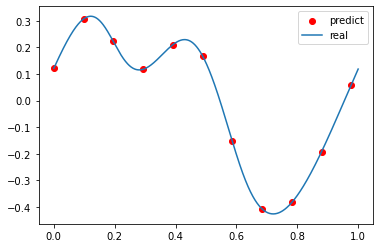

In [29]:
test_x,test_y=x_test[0:1].to(device),y_test[0]
print(model(test_x).view(1,-1).size())
predict=model(test_x).view(-1).cpu().detach().numpy()
print(predict.size)
plt.scatter(np.linspace(0,1,predict.size)[::100],predict[::100],label='predict',c='r')
plt.plot(np.linspace(0,1,test_y.size()[0]),test_y.numpy(),label='real')
plt.legend(loc='best')

接下来对之前用DeepONet求解过的积分算子采用FNO进行求解

重新设置超参数

In [27]:
batch_size = 20
learning_rate = 0.005
gamma = 0.999

epochs = 500
step_size = 50

modes = 16#线性变换R所要保留的频率数
width = 64#线性变换的层数

首先导入数据

In [29]:
d=np.load("antiderivative_aligned_train.npz",allow_pickle=True)
X_train=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_train=d["y"].astype(np.float32)
X_train=[torch.from_numpy(X_train[0]).view(150,100,1).to(device),torch.from_numpy(X_train[1]).to(device)]
y_train=torch.from_numpy(y_train).to(device)
print(X_train[0].shape,X_train[1].shape,y_train.shape)
train_loader=torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train[0],y_train),
    batch_size=batch_size,
    shuffle=True,
)
d=np.load("antiderivative_aligned_test.npz",allow_pickle=True)
X_test=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_test=d["y"].astype(np.float32)
X_test=[torch.from_numpy(X_test[0]).view(1000,100,1).to(device),torch.from_numpy(X_test[1]).to(device)]
y_test=torch.from_numpy(y_test).to(device)
print(X_test[0].shape,X_test[1].shape,y_test.shape)

torch.Size([150, 100, 1]) torch.Size([100, 1]) torch.Size([150, 100])
torch.Size([1000, 100, 1]) torch.Size([100, 1]) torch.Size([1000, 100])


我们再实例化一个model，用来训练积分算子神经网络

In [30]:
model1=FNO1d(modes,width).to(device)
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(model1.parameters(),lr=learning_rate)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma)
for epoch in range(epochs):
    for x,y in train_loader:
        output=model1(x)
        loss=loss_func(output.view(batch_size,-1),y.view(batch_size,-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    if epoch%50==0:
        model1.eval()
        with torch.no_grad():
            train_predict=model1(X_train[0])
            loss_train=loss_func(train_predict.view(150,-1),y_train.view(150,-1)).mean().item()
            test_predict=model1(X_test[0])
            loss_test=loss_func(test_predict.view(1000,-1),y_test.view(1000,-1)).mean().item()
            print("epoch:{}".format(epoch))
            print("train loss:{:.6f}, test loss:{:.6f}".format(loss_train,loss_test))
        model1.train()
torch.save(model1.state_dict(),'intFNO.pt')
        

epoch:0
train loss:0.170201, test loss:0.152591
epoch:50
train loss:0.000124, test loss:0.000189
epoch:100
train loss:0.000510, test loss:0.000612
epoch:150
train loss:0.000014, test loss:0.000094
epoch:200
train loss:0.000008, test loss:0.000065
epoch:250
train loss:0.000006, test loss:0.000056
epoch:300
train loss:0.000004, test loss:0.000051
epoch:350
train loss:0.000005, test loss:0.000049
epoch:400
train loss:0.000003, test loss:0.000046
epoch:450
train loss:0.000003, test loss:0.000044


将测试数据集中的一组数据可视化

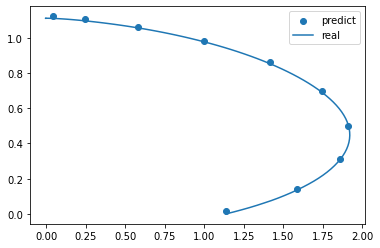

In [38]:
test_x=X_test[0][:1].to(device)
predict=model1(test_x)
plt.scatter(test_x.cpu().view(-1).detach().numpy()[::10],predict.view(-1).cpu().detach().numpy()[::10],label='predict')
plt.plot(test_x.cpu().view(-1).detach().numpy(),y_test[0].cpu().view(-1).detach().numpy(),label='real')
plt.legend(loc='best')